In [1]:
import os
import numpy as np
from os import path
import pandas as pd
from matplotlib import pyplot as plt

# Описание DF

КОНТЕНТ
Прогнозирование загрязнения воздуха
Набор данных о качестве воздуха.

Это набор данных, который сообщает о погоде и уровне загрязнения каждый час в течение пяти лет в посольстве США в Пекине, Китай.

Данные включают дату и время, загрязнение, называемое концентрацией PM2,5, а также информацию о погоде, включая точку росы, температуру, давление, направление ветра, скорость ветра и совокупное количество часов снега и дождя. Полный список функций в необработанных данных выглядит следующим образом:

* Нет: номер строки
* год: год данных в этой строке
* месяц: месяц данных в этой строке
* день: день данных в этой строке
* час: час данных в этой строке
* pm2,5: концентрация PM2,5
* DEWP: точка росы
* TEMP: Температура
* PRES: Давление
* cbwd: Комбинированное направление ветра
* Iws: Суммарная скорость ветра
* Is: Суммарное количество часов снега
* Ir: Суммарное количество часов дождя

  источник: https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate?select=LSTM-Multivariate_pollution.csv

In [2]:
base_dir = os.path.abspath(os.curdir) + r'/data'

df = pd.read_csv(path.join(os.sep, base_dir, 'LSTM-Multivariate_pollution.csv'))
df = df.drop(['wnd_dir'], axis=1)
df.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0


In [3]:
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [4]:
df.shape

(43800, 8)

### Проверка NaN в DF

In [5]:
df['num_nulls'] = df[['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']].isnull().sum(axis=1)
df[(df['num_nulls'] > 0)]

,date,pollution,dew,temp,press,wnd_spd,snow,rain,num_nulls


из результатов выборки видно, что пропусков в df нет

In [6]:
# типы данных в df
df.dtypes

date          object
pollution    float64
dew            int64
temp         float64
press        float64
wnd_spd      float64
snow           int64
rain           int64
num_nulls      int64
dtype: object

In [7]:
df['date'] = pd.to_datetime(df.date , format = '%Y-%m-%d %H:%M:%S')
df = df.drop(['num_nulls'], axis=1)
data = df.drop(['date'], axis=1)
data.index = df.date
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0


In [8]:
data.dtypes

pollution    float64
dew            int64
temp         float64
press        float64
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [9]:
data.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain'], dtype='object')

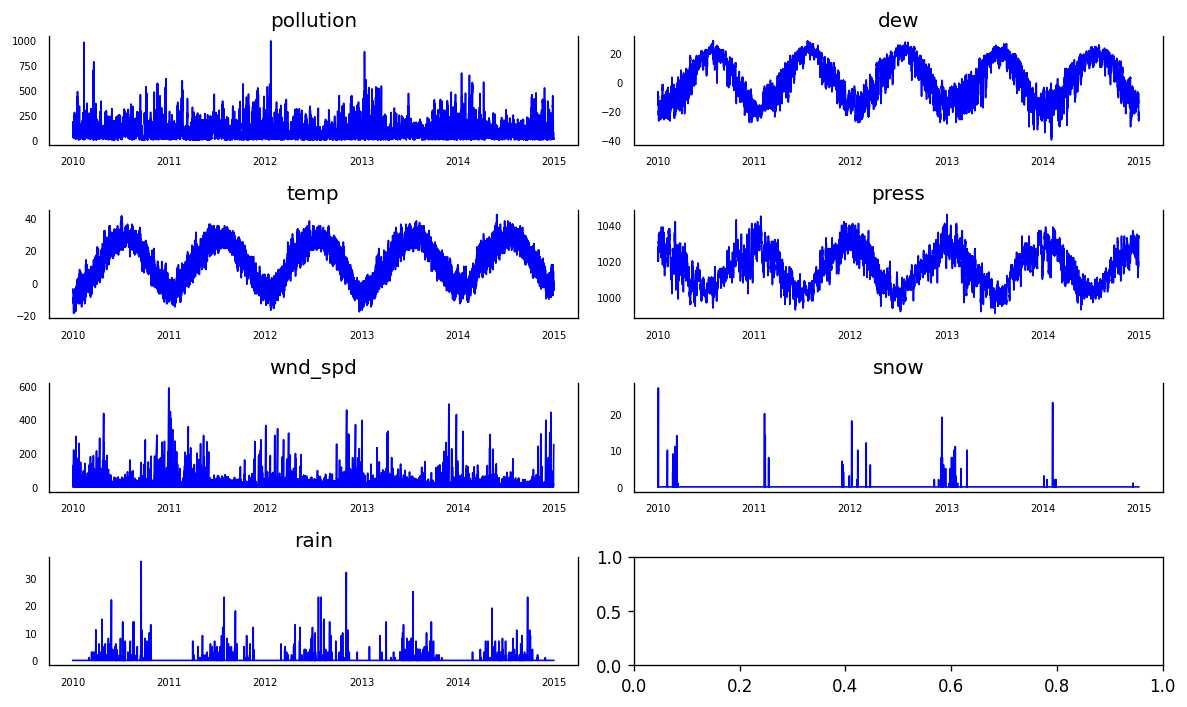

In [10]:
# Plot
df = data.copy()
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    try:
        data = df[df.columns[i]]
        ax.plot(data, color='blue', linewidth=1)
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    except IndexError:
        continue

plt.tight_layout();

In [11]:
# granger causality tests
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [12]:
grangers_causation_matrix(df, variables = df.columns) 

/Users/noone/Time_Series/Time_Series/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/noone/Time_Series/Time_Series/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/noone/Time_Series/Time_Series/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/noone/Time_Series/Time_Series/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/noone/Time_Series/Time_Series/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.w

,pollution_x,dew_x,temp_x,press_x,wnd_spd_x,snow_x,rain_x
pollution_y,1.0000,0.0000,0.0,0.0000,0.0000,0.1349,0.0000
dew_y,0.0000,1.0000,0.0,0.0000,0.0000,0.0056,0.4654
temp_y,0.0000,0.0000,1.0,0.0000,0.0000,0.2351,0.0032
press_y,0.0000,0.0000,0.0,1.0000,0.0000,0.0092,0.0028
wnd_spd_y,0.0000,0.0000,0.0,0.0000,1.0000,0.0866,0.4817
snow_y,0.4986,0.0269,0.0,0.0002,0.0339,1.0000,0.8229
rain_y,0.0472,0.0000,0.0,0.0000,0.4764,0.6450,1.0000


## Коинтегральность


In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [14]:

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
pollution ::  10087.51  > 111.7797  =>   True
dew    ::  6362.94   > 83.9383   =>   True
temp   ::  4246.18   > 60.0627   =>   True
press  ::  2415.81   > 40.1749   =>   True
wnd_spd ::  1102.59   > 24.2761   =>   True
snow   ::  62.46     > 12.3212   =>   True
rain   ::  0.0       > 4.1296    =>   False


In [15]:
#Функция теста Адфулера на стационарность
from statsmodels.tsa.stattools import adfuller

def adfuller_test(ts, signif=0.05, name='', verbose=False, alpha = 0.05):
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [103]:
# Разделяем выборку на трейн и тест
#creating the train and validation set
train = df[:int(0.8*(len(data)))]
test = df[int(0.8*(len(data))):]

In [17]:
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')

Тест Дики-Фуллера ряда pollution :
Test Statistic                   -19.095145
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    34987.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Тест Дики-Фуллера ряда dew :
Test Statistic                    -5.458713
p-value                            0.000003
#Lags Used                        52.000000
Number of Observations Used    34987.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Тест Дики-Фуллера ряда temp :
Test Statistic                    -3.632136
p-value                            0.005176
#Lags Used                        49.000000
Number of Observations Used    34990.000

* Значение p всех рядов меньше 5.0%. Можно сделать вывод, что ряды стационарные 

In [74]:
# Чтобы выбрать правильный порядок модели VAR, мы итеративно подбираем возрастающие порядки модели VAR
# и выбираем порядок, который дает модель с наименьшим AIC.
from statsmodels.tsa.vector_ar.var_model import VAR


model = VAR(train)

/Users/noone/Time_Series/Time_Series/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [76]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,29.42,29.42,5.988e+12,29.42
1,9.610,9.623,1.491e+04,9.614
2,9.362,9.387,1.164e+04,9.370
3,9.188,9.225,9778.,9.200
4,9.135,9.184,9272.,9.150
5,9.116,9.177,9097.,9.135
6,9.094,9.167,8902.,9.117
7,9.084,9.169,8817.,9.111
8,9.076,9.172,8743.,9.107
9,9.062,9.170,8622.,9.097


In [77]:
# заполняем модель с лучшими параметрами
model_fitted = model.fit(365)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Dec, 2023
Time:                     13:07:01
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    13.1272
Nobs:                     34675.0    HQIC:                   10.1552
Log likelihood:          -478486.    FPE:                    6419.17
AIC:                      8.76517    Det(Omega_mle):         3901.77
--------------------------------------------------------------------
Results for equation pollution
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 58.873923        53.550633            1.099           0.272
L1.pollution           0.914530         0.005614          162.892           0.000
L1.dew                 2.019506         0.121699    

In [83]:
lag_order = 365
print(lag_order) 

365


### проверяяем оставшуюся последовательную корреляцию

In [84]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

pollution : 2.0
dew : 2.0
temp : 2.0
press : 2.0
wnd_spd : 2.0
snow : 2.0
rain : 2.0


In [85]:
# данные для предсказания
forecast_input = train.values[-lag_order:]
forecast_input

array([[210.  , -13.  ,  -2.  , ...,   0.89,   0.  ,   0.  ],
       [247.  , -11.  ,  -2.  , ...,   1.78,   0.  ,   0.  ],
       [284.  , -12.  ,  -1.  , ...,   0.89,   0.  ,   0.  ],
       ...,
       [ 23.  , -21.  ,   7.  , ..., 125.6 ,   0.  ,   0.  ],
       [ 20.  , -21.  ,   6.  , ..., 130.52,   0.  ,   0.  ],
       [ 23.  , -20.  ,   7.  , ..., 137.67,   0.  ,   0.  ]])

In [97]:
# Forecast
nobs = 365 # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns)
df_forecast

,pollution,dew,temp,press,wnd_spd,snow,rain
date,,,,,,,
2014-12-16 19:00:00,37.416146,-20.358375,6.451143,1014.335535,131.935201,0.011266,0.061154
2014-12-16 20:00:00,42.561655,-20.183867,5.262676,1014.481866,134.781759,0.125523,0.005560
2014-12-16 21:00:00,30.213276,-20.109557,4.603921,1014.675855,121.684579,0.137622,-0.235271
2014-12-16 22:00:00,38.213753,-19.093766,3.652265,1014.597691,118.018872,0.165302,-0.047722
2014-12-16 23:00:00,40.272979,-19.303110,2.945620,1014.619501,114.461545,0.076251,0.169089
...,...,...,...,...,...,...,...
2014-12-31 19:00:00,118.940206,-11.598040,2.532272,1021.035884,39.007909,0.020600,-0.143781
2014-12-31 20:00:00,116.363304,-11.468611,2.543755,1020.961583,38.537581,0.039920,-0.229903
2014-12-31 21:00:00,114.767831,-11.502125,2.194099,1020.789080,36.506906,0.056151,-0.209898


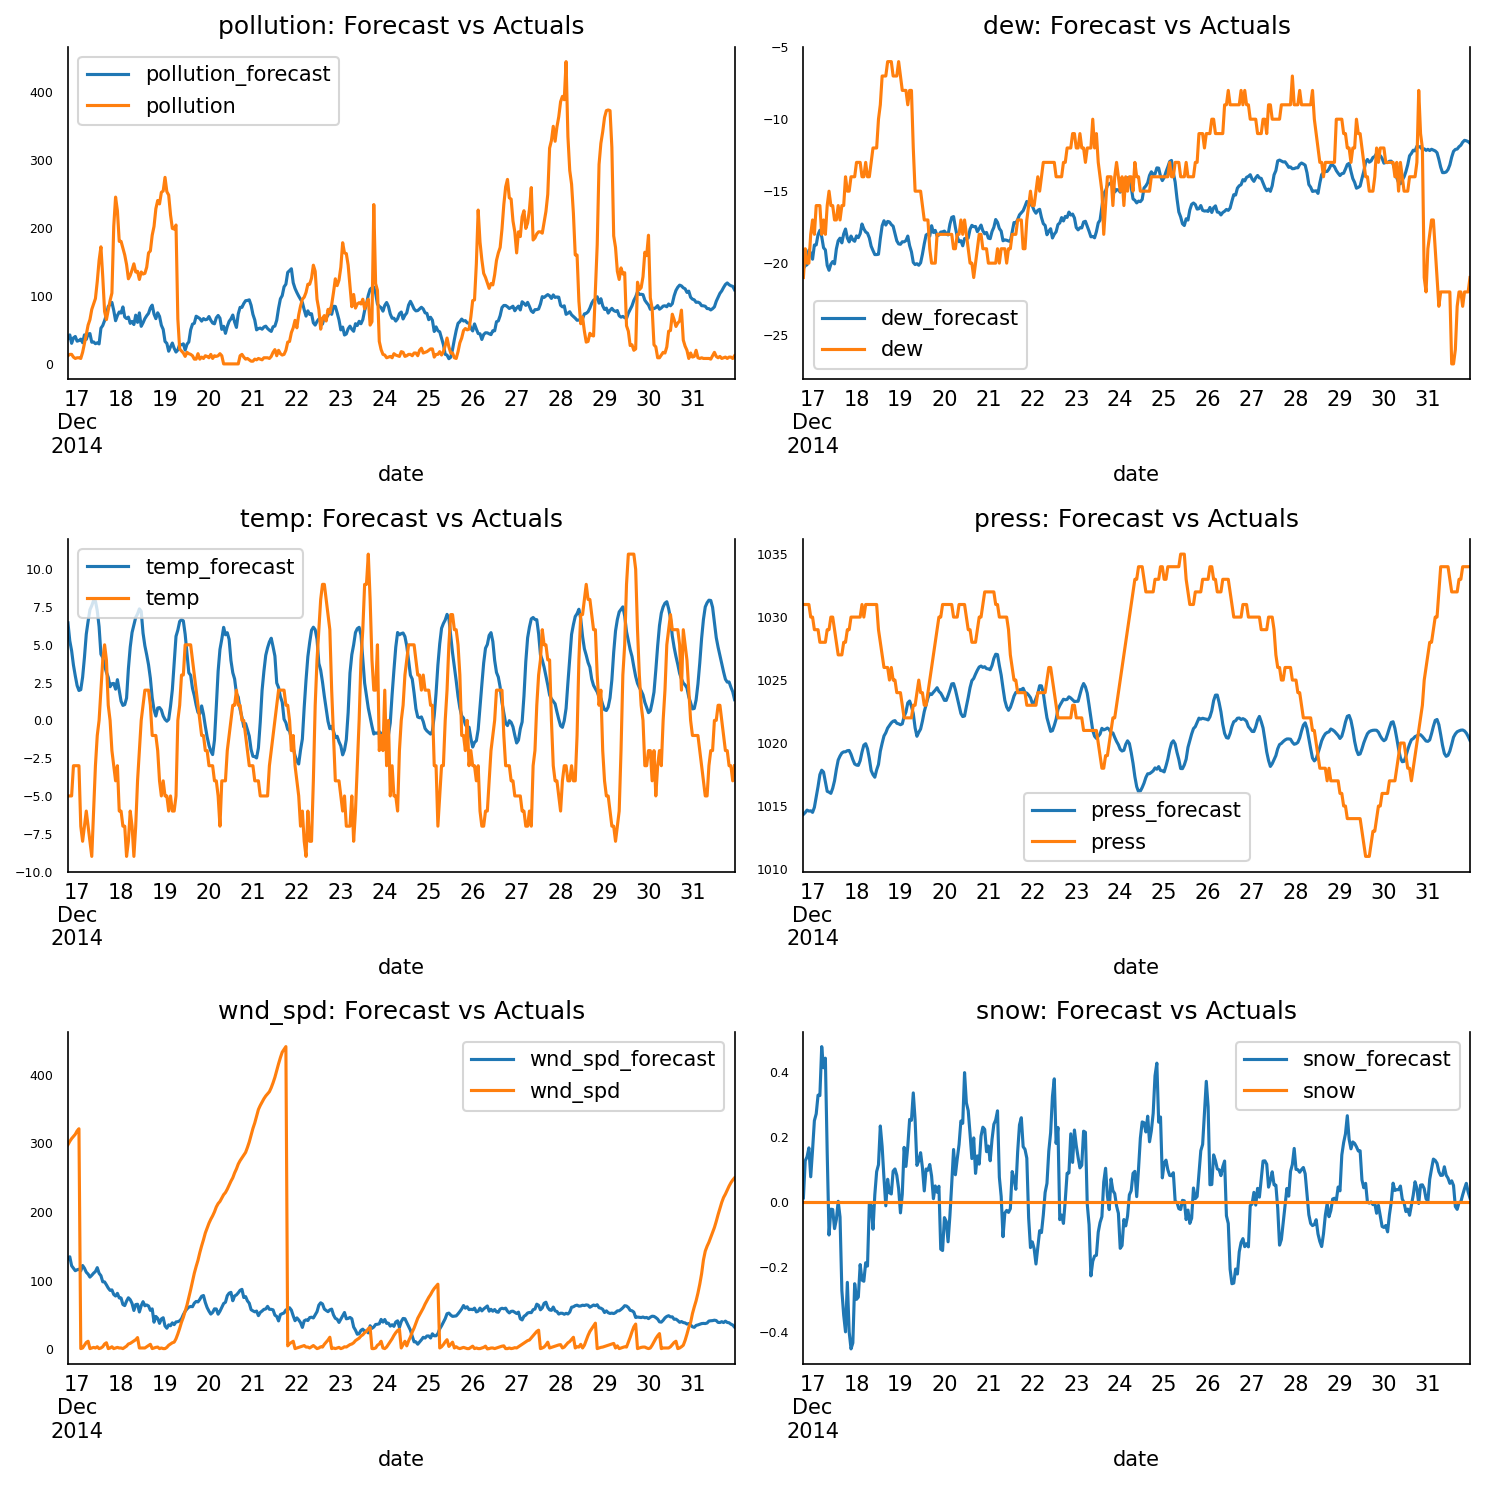

In [98]:
# отрисовываем


fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col].plot(legend=True, ax=ax, label=f"{str(col) + '_forecast'}").autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


In [108]:
# Метрики!
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import acf


def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [109]:
cols = test.columns.to_list()

for vi in range(len(cols)):
    print(f'Forecast Accuracy of: {cols[vi]}')
    n1 = f"{cols[vi]}"
    accuracy_prod = forecast_accuracy(df_forecast[n1].values, np.array(test.iloc[len(test) - 365: len(test),vi]))
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))

Forecast Accuracy of: pollution
mape :  inf
me :  -22.1459
mae :  78.0206
mpe :  inf
rmse :  100.349
corr :  0.072
minmax :  0.622
Forecast Accuracy of: dew
mape :  0.3147
me :  -1.7475
mae :  3.6411
mpe :  0.2222
rmse :  4.8148
corr :  0.0673
minmax :  -0.3406
Forecast Accuracy of: temp
mape :  inf
me :  3.5577
mae :  5.0207
mpe :  nan
rmse :  6.2674
corr :  0.0728
minmax :  inf
Forecast Accuracy of: press
mape :  0.0068
me :  -5.3121
mae :  6.9597
mpe :  -0.0051
rmse :  8.4729
corr :  -0.1157
minmax :  0.0068
Forecast Accuracy of: wnd_spd
mape :  15.2715
me :  -10.8289
mae :  78.3444
mpe :  14.8812
rmse :  109.3724
corr :  0.1729
minmax :  0.7949
Forecast Accuracy of: snow
mape :  inf
me :  0.046
mae :  0.1156
mpe :  nan
rmse :  0.1512
corr :  nan
minmax :  inf
Forecast Accuracy of: rain
mape :  inf
me :  -0.0299
mae :  0.2104
mpe :  nan
rmse :  0.2627
corr :  nan
minmax :  inf


/var/folders/62/y6pdrbb503l9t095f2_2wsbm0000gn/T/ipykernel_2816/2368997218.py:7: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
/var/folders/62/y6pdrbb503l9t095f2_2wsbm0000gn/T/ipykernel_2816/2368997218.py:10: RuntimeWarning: divide by zero encountered in divide
  mpe = np.mean((forecast - actual)/actual)   # MPE
/Users/noone/Time_Series/Time_Series/venv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/62/y6pdrbb503l9t095f2_2wsbm0000gn/T/ipykernel_2816/2368997218.py:17: RuntimeWarning: divide by zero encountered in divide
  minmax = 1 - np.mean(mins/maxs)             # minmax
/Users/noone/Time_Series/Time_Series/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/noone/Time_Series/Time_

## Нейронка

In [116]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

2023-12-22 13:43:16.047025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [133]:
base_dir = os.path.abspath(os.curdir) + r'/data'

df = pd.read_csv(path.join(os.sep, base_dir, 'LSTM-Multivariate_pollution.csv'))
df = df.drop(['wnd_dir'], axis=1)
df.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0


In [134]:
data = df.drop(['date'], axis=1)
data.index = df.date

In [135]:
# кол-во элементов для тестовой выборки
test_split_number=round(len(df)*0.25)
test_split_number

10950

In [136]:
# разбиваем на тест и трейн
df = data.copy()
df_for_training=df[:-test_split_number]
df_for_testing=df[-test_split_number:]


print(df_for_training.shape)
print(df_for_testing.shape)

(32850, 7)
(10950, 7)


In [137]:
# нормировка 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [138]:
df_for_training_scaled

array([[0.12977867, 0.22807018, 0.25      , ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.24561404, 0.25      , ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995976, 0.31578947, 0.23333333, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.68421053, 0.68333333, ..., 0.0145091 , 0.        ,
        0.        ],
       [0.01207243, 0.68421053, 0.68333333, ..., 0.01985816, 0.        ,
        0.        ],
       [0.01207243, 0.68421053, 0.68333333, ..., 0.0229172 , 0.        ,
        0.        ]])

In [141]:
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_testing_scaled.shape

(10950, 7)

In [142]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY) 

In [143]:
n_past = 25 # количество предсказанных точек

trainX,trainY=createXY(df_for_training_scaled, n_past)

testX,testY=createXY(df_for_testing_scaled, n_past)

In [144]:
trainX.shape

(32825, 25, 7)

In [145]:
testX.shape

(10925, 25, 7)

In [147]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [151]:
# собираем lstm-ку
def build_model(optimizer="adam", npas = n_past, icol = 7):
    grid_model = Sequential()
    grid_model.add(LSTM(20 + n_past,return_sequences=True,input_shape=(n_past,icol)))
    grid_model.add(LSTM(20 + n_past))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(model=build_model,verbose=1, fit__validation_data=(testX,testY))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [ ]:
grid_search = grid_search.fit(trainX, trainY)

Epoch 1/8
1026/1026 [==============================] - 61s 51ms/step - loss: 0.0024 - val_loss: 9.7440e-04
Epoch 2/8
1026/1026 [==============================] - 45s 44ms/step - loss: 0.0011 - val_loss: 7.3838e-04
Epoch 3/8
1026/1026 [==============================] - 44s 43ms/step - loss: 9.8661e-04 - val_loss: 6.3624e-04
Epoch 4/8
1026/1026 [==============================] - 44s 43ms/step - loss: 8.7272e-04 - val_loss: 6.0608e-04
Epoch 5/8
1026/1026 [==============================] - 44s 43ms/step - loss: 8.4839e-04 - val_loss: 6.0470e-04
Epoch 6/8
1026/1026 [==============================] - 45s 43ms/step - loss: 8.3398e-04 - val_loss: 5.9891e-04
Epoch 7/8
1026/1026 [==============================] - 49s 48ms/step - loss: 8.1995e-04 - val_loss: 6.0972e-04
Epoch 8/8
1026/1026 [==============================] - 15s 13ms/step
Epoch 1/8
1026/1026 [==============================] - 55s 46ms/step - loss: 0.0023 - val_loss: 9.8018e-04
Epoch 2/8
1026/1026 [==============================] - 